# Hardcode function Tool Calling Agent so now it's fully agentic with Memory


1. actually first it is going through the chatbot
2. and then calling the tools
3. and then sending the information back to the LLM to do the reasoning

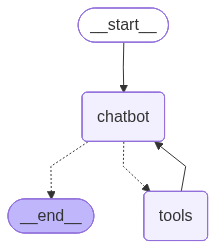

In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv

load_dotenv()

c:\Users\virub\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

1. Define a State

In [2]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messags' function
    # in the annotation defines how this state key should b updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

integrate the tools with this LLM

In [3]:
# hard coded values
@tool
def get_stock_price(symbol: str)-> float:
    '''Returns the current price of a stock given the stock symbol
    :param symbol: stock symbol
    '''
    return {
        "MSFT": 200.43,
        "AAPL": 50.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)


# intergrate the hardcoded tool with LLM
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm

ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000002682436EA80>, default_metadata=())

In [4]:
tools = [get_stock_price]

llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000002682436EA80>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_stock_price', 'description': 'Returns the current price of a stock given the stock symbol\n    :param symbol: stock symbol', 'parameters': {'properties': {'symbol': {'type': 'string'}}, 'required': ['symbol'], 'type': 'object'}}}]}, config={}, config_factories=[])

## Now create a chatbot with tools

### Call the tool only required, otherwise don't call it

1. to do this we need to use **tool_condition_edge()**
2. If a person is asking the stock price then only call this call this tool, otherwise don't call it
3. Here tool_conditional_edge start from the *chatbot* and this tools_condition calls either tool or __end__

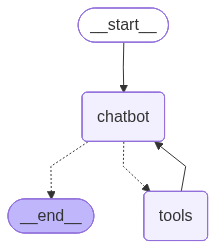

In [5]:
def chatbot(state: State)-> State:
    return {"messages": llm_with_tools.invoke(state['messages'])}


# create a builder
builder = StateGraph(State)
print(builder)

# add nodes
builder.add_node(chatbot)
builder.add_node('tools', ToolNode(tools))

# --------------------------------Here we need to add one edge to go back to the LLM and do the math calc -----------------------------
# add edges
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()
graph


---------------- Here it is going back to the LLM so it is become a agenti now --------------------

In [6]:
question = "I wanted to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"
state = graph.invoke({"messages": [{"role": "user", "content":question}]})
response = state['messages'][-1].content

In [7]:
state

{'messages': [HumanMessage(content='I wanted to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='41762957-5da6-4662-95f4-df6de22f29c3'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_stock_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='lc_run--8d7cf59b-4e95-4c73-b853-f5f9ba24900a-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AMZN'}, 'id': '759ca1dc-854f-441b-bf34-9741597da67a', 'type': 'tool_call'}, {'name': 'get_stock_price', 'args': {'symbol': 'MSFT'}, 'id': 'ac8c62cf-9ec7-4d0f-83c8-692aada39bb2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 16, 'total_tokens': 72, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='150.0', name='get_stock_price', i

In [8]:
print(response)

The current price for AMZN is $150.0, so 20 shares would cost $3000.0. The current price for MSFT is $200.43, so 15 shares would cost $3006.45. The total cost for both would be $6006.45.


# Memory

1. when you want to store conversation you need a memory to store the context

In [9]:
# state = None

# while True:
#     in_message = input("You: ")
    
#     if in_message.lower() in {"quit", "exit"}:
#         break
#     if state is None:
#         state: State = {"messages": [{"role": "user", "content": in_message}]}
#     else:
#         state['messages'].append({"role": "user", "content": in_message})
    
#     state = graph.invoke(state)
#     print(state["messages"])
#     print("Bot: ", state['messages'][-1].content)


# # This is simple python code to store the previous history
# # basically here we are appending the conversations to the normal python list
# # but it is not an efficient way of doing it
# # However the langgraph provides the memory concept to store the chat history

## Let's see what happens if we don't use memory

In [10]:
question = "I wanted to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"
state = graph.invoke({"messages": [{"role": "user", "content":question}]})
response = state['messages'][-1].content

In [11]:
response

'The current price for AMZN is $150.0, so 20 shares would cost $3000.0. The current price for MSFT is $200.43, so 15 shares would cost $3006.45. The total cost would be $6006.45.'

In [12]:
question = "Using the current price tell me the total price of 10 RIL stocks and add it to the Previous total"
state = graph.invoke({"messages": [{"role": "user", "content":question}]})
response = state['messages'][-1].content
response

"I can get you the current price of 10 RIL stocks, but I don't have access to your previous total. Could you please provide the previous total, or let me know if you want to proceed without it?"

----- SEE HERE IT IS UNABLE TO GET THE PREVIOUS TOTAL BECAUSE, IT DOESN'T HAVE THE PREVIOUS HISTORY -------------

## Add the memory to the Agent

1. import the MemorySaver from the langgraph.checkpoint
2. add the memory while compiling the builder (graph)
3. add config before invoking

In [13]:
# LET'S IMPORT THE MEMORYSAVER FROM LANGGRAPH

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
memory

------- now give this memory at the compile stage ----------

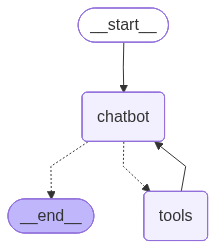

In [14]:
def chatbot(state: State)-> State:
    return {"messages": llm_with_tools.invoke(state['messages'])}


# create a builder
builder = StateGraph(State)
print(builder)

# add nodes
builder.add_node(chatbot)
builder.add_node('tools', ToolNode(tools))

# --------------------------------Here we need to add one edge to go back to the LLM and do the math calc -----------------------------
# add edges
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)

# ------------------------------- Here we need to provide the memory to store the previous chat history --------------------------------
graph = builder.compile(checkpointer=memory)
graph

----------- add the config before invoking the agent -------------------

In [15]:
config1 = {'configurable': {'thread_id': '1'}}

question = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"
state = graph.invoke({"messages": [{"role": "user", "content":question}]}, config=config1)
print(state['messages'][-1].content)

The current price for AMZN is $150 and for MSFT is $200.43.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.43 = $3006.45.
Therefore, the total cost for both is $3000 + $3006.45 = $6006.45.


In [16]:
question = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total"
state = graph.invoke({"messages": [{"role": "user", "content":question}]}, config=config1)
print(state['messages'][-1].content)

The current price of RIL is $87.6. The total price of 10 RIL stocks is 10 * $87.6 = $876. Adding this to the previous total of $6006.45, the new total is $6006.45 + $876 = $6882.45.


Create different thread id

In [17]:
config2 = {'configurable': {'thread_id': '2'}}

question = "Tell me the current price of 5 AAPL stocks?"
state = graph.invoke({"messages": [{"role": "user", "content":question}]}, config=config2)
print(state['messages'][-1].content)

The current price of one AAPL stock is $50.4. Therefore, the current price of 5 AAPL stocks is $252.0.


In [18]:
config2 = {'configurable': {'thread_id': '2'}}

question = "Tell me the current price of 3 MSFT stocks? and add it to the previous total"
state = graph.invoke({"messages": [{"role": "user", "content":question}]}, config=config1)
print(state['messages'][-1].content)

The current price of MSFT is $200.43. So, the price of 3 MSFT stocks is 3 * $200.43 = $601.29. Adding this to the previous total of $6882.45, the new total is $6882.45 + $601.29 = $7483.74.


**** Add memory (MemorySaver) is not only just maintaining the memory for chatconversation around different threads

It is also used resume complex state at any time for recovery, human-in-the-loop workflows, time travel interactions, and more.***



# LangSMith

# LangSmith

1. After building the Langgraph Agentic AI application and then your application is ready to deploy into the production. You should understand how many api calls your Agent is calling, and what is cost and monitoring purposes, latency and some kind of trace of output so that you know that your customers are given the right answers and you can perform some kind of AUdit
2. Langsmith is a tool that allows you to do this. we can incorporate with our code


1. Login to the langsmith  https://smith.langchain.com/o/2eb4db4e-0732-4b9c-aaad-a16abcfa92e5?paginationModel=%7B%22pageIndex%22%3A0%2C%22pageSize%22%3A5%7D
2. go home
3. Tracing projects -> New Project -> Generate API key 

In [ ]:
# %pip install langsmith

In [21]:
from langsmith import traceable

@traceable
def call_graph(query: str):
    state = graph.invoke({"messages": [{"role": "user", "content":query}]}, config=config1)
    return state['messages'][-1].content


call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost")

'Okay, I can help you with that.\n\nBased on the current stock prices:\n- AMZN: $150\n- MSFT: $200.43\n\nThe cost of 20 AMZN stocks would be 20 * $150 = $3000\nThe cost of 15 MSFT stocks would be 15 * $200.43 = $3006.45\n\nTherefore, the total cost for buying 20 AMZN stocks and 15 MSFT stocks would be $3000 + $3006.45 = $6006.45'